In [2]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [3]:
# Load the data
train_data = pd.read_csv('data/X_train.csv')
Y_train = pd.read_csv('data/Y_train.csv')
test_data = pd.read_csv('data/X_test.csv')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4864\2945874689.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('data/X_train.csv')


In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [5]:
#obtain all the numerical features
numerical_features = all_features.dtypes[all_features.dtypes != 'object'].index
#apply standardization to each feature
all_features[numerical_features] = all_features[numerical_features].apply( lambda x: (x-x.mean()) / x.std() )
#replace missing values with 0
all_features[numerical_features] = all_features[numerical_features].fillna(0)

In [6]:
#one-hot encoding consider missing values as a category.
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(318851, 2918)

In [65]:
# Tách dữ liệu thành tập huấn luyện và tập kiểm tra
n_train = train_data.shape[0]
train_features = all_features[:n_train]
test_features = all_features[n_train:]
train_labels = Y_train.values

# Tách tập huấn luyện thành tập train và validation
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)



In [66]:

# Xây dựng mô hình MLP
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(train_features.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1)  # Output layer
])


d:\App\anacoda\envs\ai_class\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Định nghĩa early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)



In [68]:
# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)



Epoch 1/200
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - loss: 16890430464.0000 - mae: 79751.7734 - val_loss: 16787170304.0000 - val_mae: 79894.5625 - learning_rate: 0.0010
Epoch 2/200
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 16689675264.0000 - mae: 79832.8359 - val_loss: 16392907776.0000 - val_mae: 80008.9844 - learning_rate: 0.0010
Epoch 3/200
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 16276932608.0000 - mae: 80048.7578 - val_loss: 15842813952.0000 - val_mae: 80235.7500 - learning_rate: 0.0010
Epoch 4/200
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 15718301696.0000 - mae: 80266.6953 - val_loss: 15193843712.0000 - val_mae: 80482.0156 - learning_rate: 0.0010
Epoch 5/200
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 14981817344.0000 - mae: 80461.1562 - val_loss: 14404496384.0000 - val_mae: 80704.4688 - learning_rate: 0.0010
Epoch 6/200
3189/3189 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - loss: 14234389504.0000 - mae: 80840.5703 - val_loss: 13527982080.0

In [69]:
# Đánh giá mô hình trên tập validation
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")



Validation Loss: 8470050816.0000
Validation MAE: 79768.4375


In [1]:
# Cell 6: Dự đoán và tạo file submission
test_predictions = model.predict(test_features)

# Tạo DataFrame submission với index làm Id
submission = pd.DataFrame({'TARGET': test_predictions.flatten()})
submission.index.name = 'ID'
submission.index += 1  
submission.to_csv('submission.csv')


1993/1993 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


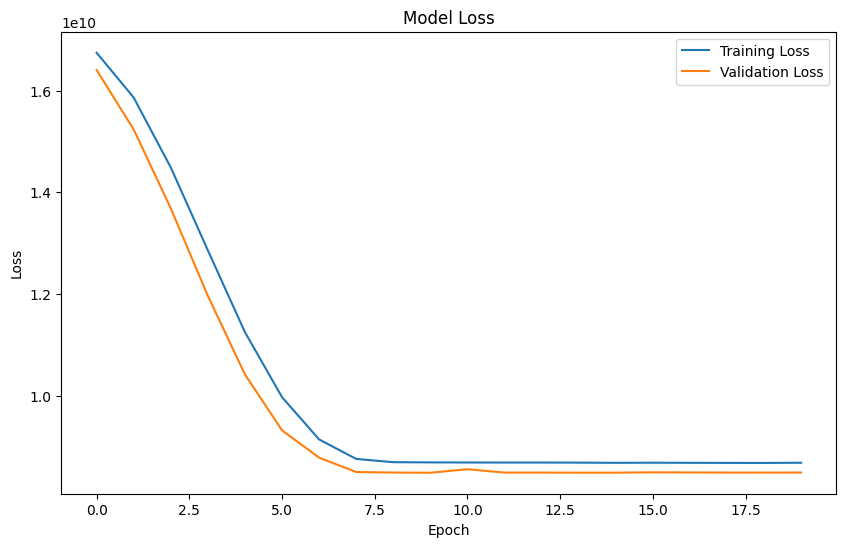

In [73]:
# Vẽ đồ thị loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()